In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools


import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils.class_weight import compute_sample_weight


from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

import cartopy
import numpy as np
from cartopy.crs import PlateCarree
import requests
import json
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans

from math import radians
from numpy import cos, sin, arcsin, sqrt
import haversine as hs
import requests
import json
from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.space import Real, Categorical, Integer


from time import time
import pprint
from sklearn.metrics import make_scorer
import joblib
from functools import partial



import warnings
warnings.filterwarnings('ignore')


### Fetching coordinates of South Africa Provinces using the positionstack API

In [35]:
def get_prov_list():
    ACCESS_KEY = '1a2febdd5530824a8bbc342c32aee3db'
    provinces = [
        'Eastern Cape',
        'Free State',
        'Gauteng',
        'KwaZulu-Natal',
        'Limpopo',
        'Mpumalanga',
        'Northern Cape',
        'North West',
        'Western Cape',
    ]   
    prov_list=[]
    for province in provinces:
        prov_dict={}
        url = 'http://api.positionstack.com/v1/forward?access_key=' + ACCESS_KEY+'&query='+province
        response = requests.get(url)
        prov_dict['province']=province
        prov_dict['lon']=response.json()['data'][0]['longitude']
        prov_dict['lat']=response.json()['data'][0]['latitude']
        prov_list.append(prov_dict)
    
    return prov_list

prov_list=get_prov_list()

In [36]:
# coordinates of major cities in Africa
cities_data = {
    'city': ['cape_town', 'Durban', 'Johannesburg', 'Soweto', 'Pretoria', 'Port_Elizabeth', 'PieterMaritzburg', 'Benoni', 'Tembisa', 'East_London', 'Vereeniging', 'Bloemfontein'],
    'lon': [18.423, 31.029, 28.044, 27.858, 28.188, 25.615, 30.393, 28.321, 28.227, 27.912, 27.926, 26.214],
    'lat': [-33.926, -29.858, -26.202, -26.268, -25.745, -33.961, -29.617, -26.188, -25.996, -33.015, -26.673, -29.121]
}

def haversine(row, city_index):
    lon1 = prov_list[city_index]['lon']
    lat1 = prov_list[city_index]['lat']
    lon2 = row['lon']
    lat2 = row['lat']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    km = 6367 * c
    return km



def process(filename):
    train_df = pd.read_csv('data/Train.csv')
    test_df = pd.read_csv('data/Test.csv')
    train_df['train'] = 1
    test_df['train'] = 0
    combined = pd.concat([train_df, test_df])
    combined = combined.drop(columns=['car_01', 'stv_01', 'lln_01'])
    combined = combined.drop(columns=['ADM4_PCODE','ward'])


    combined['dist_1'] = combined.apply(lambda row: haversine(row, 4), axis=1)
    combined['dist_2'] = combined.apply(lambda row: haversine(row, 2), axis=1)




    combined['Household_Size'] = combined['total_individuals'] / combined['total_households']


    if filename == 'data/Train.csv':
        return combined[combined.train == 1].drop(columns=['train'])
    elif filename == 'data/Test.csv':
        return combined[combined.train == 0].drop(columns=['train', 'target'])
   

# EDA

### Plotting the wards using latitude and longitute coordinates and coloring depending on the target value

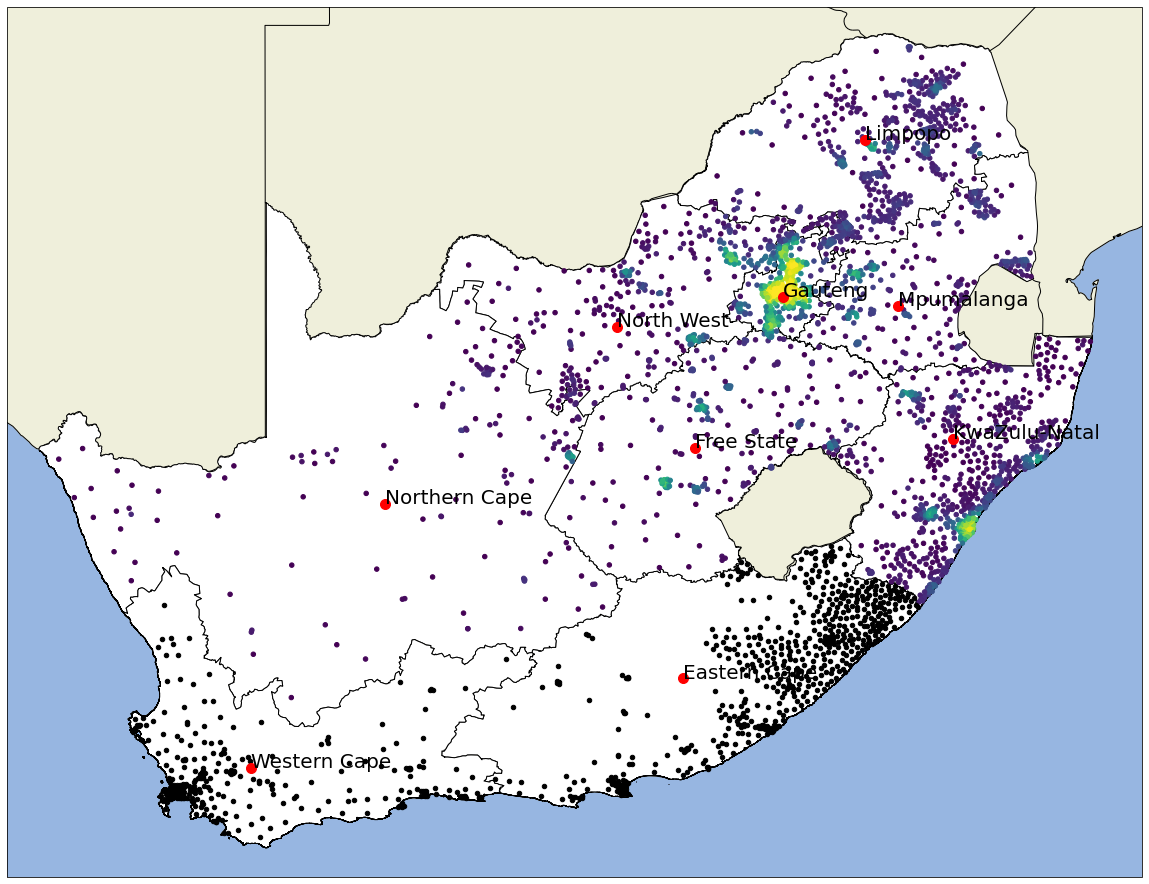

In [32]:
from cartopy.crs import LambertConformal, Mercator, Orthographic
import shapely
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader


train_data = process('data/Train.csv')
test_data = process('data/Test.csv')


fname = 'data/shapefile/gadm40_ZAF_1.shp'
shapes = list(shpreader.Reader(fname).geometries())



# coordinates of major cities in Africa
cities_data = {
    'city': ['ref', 'Stellenbosch', 'cape_town', 'Durban', 'Johannesburg', 'Soweto', 'Pretoria', 'Port_Elizabeth', 'PieterMaritzburg', 'Benoni', 'Tembisa', 'East_London', 'Vereeniging', 'Bloemfontein'],
    'lon': [30.400, 18.860151, 18.423, 31.029, 28.044, 27.858, 28.188, 25.615, 30.393, 28.321, 28.227, 27.912, 27.926, 26.214],
    'lat': [-24.202, -33.932106, -33.926, -29.858, -26.202, -26.268, -25.745, -33.961, -29.617, -26.188, -25.996, -33.015, -26.673, -29.121]
}


def add_map_features():
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)
    ax.add_geometries(shapes,PlateCarree(),edgecolor='black',facecolor='white')


plt.figure(figsize=(24, 16))
central_lon, central_lat = -10, 45
extent = [-40, 20, 30, 60]
ax = plt.axes(projection=PlateCarree())

add_map_features()

ax.scatter(train_data['lon'], train_data['lat'], c=train_data['NL'],
           transform=PlateCarree(),
           s=20,zorder=4
           )

ax.scatter(test_data['lon'], test_data['lat'], color='black',
           transform=PlateCarree(),
           s=20,zorder=4
           )


for i in range(len(prov_list)):
    ax.text(prov_list[i]['lon'], prov_list[i]['lat'],prov_list[i]['province'], transform=PlateCarree(),fontsize=20,zorder=4)
    ax.scatter(prov_list[i]['lon'], prov_list[i]['lat'], color='red', transform=PlateCarree(), s=100,zorder=4)

plt.show()


### Target distribution

In [ ]:
ax = train_data['target'].plot(kind='hist')
plt.xlabel('Percentage of households that are w-headed and have income under R19.6k/month')

### Correlations

In [ ]:
train_data.corr()['target'].sort_values(ascending=False).head(10)

In [ ]:
train_data.corr()['target'].sort_values().head(10)

In [ ]:
train_data.plot(x='pw_00', y='target', kind='scatter', alpha=0.3)

In [ ]:
train_data.plot(x='NL', y='target', kind='scatter', alpha=0.3)

## Modeling

In [ ]:
train_data = process('data/Train.csv')
X = train_data.drop(columns=['target'])
y = train_data[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=0)

In [33]:
scores ={'model':[],'RMSE':[]}
models = [LinearRegression(),XGBRegressor(),LGBMRegressor(),CatBoostRegressor(),RandomForestRegressor(),KNeighborsRegressor()]
for model in models:
    model.fit(X_train,y_train)
    scores['model'].append(model.__class__.__name__)
    scores['RMSE'].append(sqrt(mean_squared_error(y_test,model.predict(X_test))))
scores_df = pd.DataFrame(scores)
scores_df.sort_values(by='RMSE')

In [12]:
cat_reg = CatBoostRegressor()
parameters = {'depth': [8],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [3000,3500]
              }

model = GridSearchCV(
    estimator=cat_reg,
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=10,
    cv=5
)

model = CatBoostRegressor(depth=8,learning_rate=0.01,iterations=3500,verbose=1)
model.fit(X_train,y_train)

0:	learn: 10.1952695	total: 22.1ms	remaining: 1m 28s
1:	learn: 10.1232721	total: 36.3ms	remaining: 1m 12s
2:	learn: 10.0512909	total: 55.6ms	remaining: 1m 14s
3:	learn: 9.9786059	total: 68.7ms	remaining: 1m 8s
4:	learn: 9.9037289	total: 82.2ms	remaining: 1m 5s
5:	learn: 9.8314418	total: 93ms	remaining: 1m 1s
6:	learn: 9.7620073	total: 106ms	remaining: 1m
7:	learn: 9.6895520	total: 120ms	remaining: 59.8s
8:	learn: 9.6210929	total: 132ms	remaining: 58.7s
9:	learn: 9.5553701	total: 144ms	remaining: 57.3s
10:	learn: 9.4866222	total: 155ms	remaining: 56.3s
11:	learn: 9.4174021	total: 167ms	remaining: 55.4s
12:	learn: 9.3512496	total: 179ms	remaining: 54.9s
13:	learn: 9.2850836	total: 191ms	remaining: 54.4s
14:	learn: 9.2184206	total: 207ms	remaining: 55s
15:	learn: 9.1526870	total: 219ms	remaining: 54.6s
16:	learn: 9.0919845	total: 233ms	remaining: 54.6s
17:	learn: 9.0288860	total: 250ms	remaining: 55.2s
18:	learn: 8.9658881	total: 263ms	remaining: 55.2s
19:	learn: 8.9045799	total: 280ms	re

In [13]:
print("RMSE", sqrt(mean_squared_error(y_test,model.predict(X_test))))

RMSE 3.478143298758605


## Feature importance

In [21]:
train_data = process('data/Train.csv')
X = train_data.drop(columns=['target'])
y = train_data[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=0)

feature_names = [feature for feature in X_train.columns.to_list()]

In [25]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

train_data = process('data/Train.csv')
X = train_data.drop(columns=['target'])
y = train_data[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=0)

feature_names = [feature for feature in X_train.columns.to_list()]
train_pool = Pool(X_train, y_train, feature_names=feature_names)
test_pool = Pool(X_test, y_test, feature_names=feature_names)

model = CatBoostRegressor(depth=5,learning_rate=0.01,iterations=3000,verbose=1)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-59',
    num_features_to_select=20,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [26]:
print(summary)

{'selected_features': [3, 16, 17, 21, 22, 24, 25, 27, 30, 31, 33, 39, 40, 42, 45, 54, 56, 57, 58, 59], 'eliminated_features_names': ['dw_11', 'psa_02', 'lan_08', 'lan_12', 'dw_12', 'dw_13', 'lan_13', 'pw_08', 'pw_07', 'dw_05', 'pw_03', 'pg_02', 'dw_04', 'dw_03', 'dw_10', 'pg_04', 'dw_06', 'psa_03', 'lan_14', 'lan_05', 'lan_04', 'pw_04', 'total_households', 'lan_02', 'dw_08', 'pw_05', 'pw_01', 'total_individuals', 'pw_06', 'lan_11', 'pw_02', 'dw_07', 'dw_09', 'lgt_00', 'lan_10', 'lln_00', 'dw_02', 'psa_04', 'dw_00', 'lon'], 'loss_graph': {'main_indices': [0, 18, 31, 40], 'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'loss_values': [3.0790109550796907, 2.730922409695427, 2.427460778291322, 2.276357573898939, 2.2686072078970514, 2.2686072078970514, 2.2686072078970514, 2.2686072078970514, 2.2686072078970514, 2.268607207897071, 2.2877745911033927, 2.3255429

In [173]:
print("RMSE", sqrt(mean_squared_error(y_test,model.predict(X_test))))

RMSE 3.0832221101433404


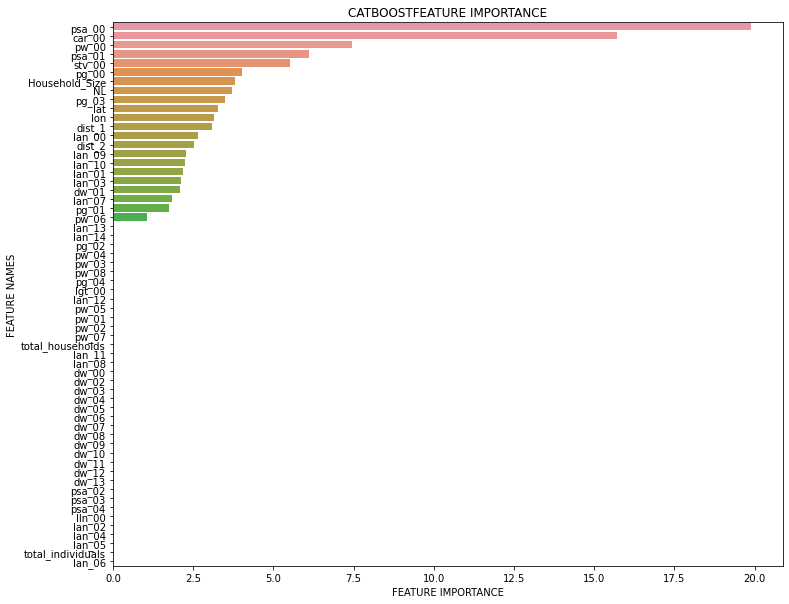

In [176]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(12,10))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
data = process('data/Train.csv')
plot_feature_importance(model.get_feature_importance(),data.drop(columns=['target']).columns.to_list(),'CATBOOST')



### Hypertuning (Bayesian Optimization) -- Takes around 5 hours

In [ ]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

In [ ]:
X = process('data/Train.csv')
X_test = process('data/Test.csv')
y = X.target
X = X.set_index('ward').drop('target', axis='columns')
X_test = X_test.set_index('ward')

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

y_stratified = pd.cut(y, bins=10, labels=False)

skf = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=0)

cv_strategy = list(skf.split(X, y_stratified))

In [ ]:
reg = CatBoostRegressor(verbose = False)
regression_loss_funcs = ['RMSE', 'Tweedie:variance_power=1.5', 
                         'Tweedie:variance_power=1.75', 'Tweedie:variance_power=1.25',
                         'Tweedie:variance_power=1.10', 'Tweedie:variance_power=1.9']

search_spaces = {
    'loss_function': Categorical(regression_loss_funcs),
    'iterations': Integer(10, 2000),
    'depth': Integer(1, 12),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'random_strength': Real(1e-9, 10, 'log-uniform'), # randomness for scoring splits
    'bagging_temperature': Real(0.0, 1.0), # settings of the Bayesian bootstrap
    'l2_leaf_reg': Integer(2, 100), # L2 regularization
   }

In [ ]:
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=cv_strategy,                                           
                    n_iter=60,                                     
                    n_points=3,                                    
                    n_jobs=-1,                              
                    iid=False,                                
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        
                    random_state=0) 

In [ ]:
overdone_control = DeltaYStopper(delta=0.0001)           
time_limit_control = DeadlineStopper(total_time=60 * 60 * 7) 
best_params = report_perf(opt, X, y,'CatBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

## Submission

In [14]:
ss = pd.read_csv('data/SampleSubmission.csv')
test = process('data/Test.csv')

test = test[X_test.columns.to_list()]
ss['target'] = model.predict(test)
version = 'catboost_feature_selection'
ss.to_csv('submissions/'+version+'.csv', index=False)

### Fetching MDB data (further details on wards)

In [3]:
url = 'https://services7.arcgis.com/oeoyTUJC8HEeYsRB/arcgis/rest/services/MDB_Wards_2016/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
response = requests.get(url)
with open('data/mdb_data.json', 'w') as outfile:
    outfile.write(str(json.dumps(response.json())))